OUTPUT:

    Government:
        GCN Accuracy: 0.5041
        GAT Accuracy: 0.4996
        GraphSAGE Accuracy: 0.5232

    New Sites:
        GCN Accuracy: 0.4965
        GAT Accuracy: 0.4891
        GraphSAGE Accuracy: Kernel Died

    Athletes:
        GCN Accuracy: 0.5169
        GAT Accuracy: 0.5080
        GraphSAGE Accuracy: 0.4994

    Public Figures:
        GCN Accuracy: 0.5036
        GAT Accuracy: 0.4981
        GraphSAGE Accuracy: 0.5139

    TV Shows:
        GCN Accuracy: 0.5143
        GAT Accuracy: 0.5197
        GraphSAGE Accuracy: 0.4980

    Politician:
        GCN Accuracy: 0.5000
        GAT Accuracy: 0.5153
        GraphSAGE Accuracy: 0.4974

    Artist:
        GCN Accuracy: 0.5035
        GAT Accuracy: 0.4928
        GraphSAGE Accuracy: Kernel Died

    Company:
        GCN Accuracy: 0.5009
        GAT Accuracy: 0.5085
        GraphSAGE Accuracy: 0.5074



    

GCN generally performs consistently across all categories, with accuracies ranging from 0.4965 to 0.5169. It shows particular strength in the "Athletes" and "TV Shows" categories.

GAT also performs consistently, with its accuracy mostly similar to GCN. Notably, it outperforms GCN in the "TV Shows" and "Politician" categories.

GraphSAGE shows mixed performance, and in two cases ("New Sites" and "Artist"), it encountered kernel errors, indicating potential inefficiencies or computational challenges with large datasets. Where it did perform, its accuracy was close to GCN and GAT.

Given the results, GCN looks to be a reliable and consistent model across several categories, particularly given the computational challenges seen with GraphSAGE.

In [1]:
import torch
import pandas as pd
import networkx as nx
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from torch_geometric.nn import GCNConv,GATConv,SAGEConv
import torch_geometric.utils as pyg_utils
from sklearn.preprocessing import LabelEncoder



In [2]:
# Load the CSV file
df = pd.read_csv('../facebook_clean_data/tvshow_edges.csv')

In [3]:
# Create a NetworkX graph from the edge list
G = nx.from_pandas_edgelist(df, 'node_1', 'node_2')

# If your nodes are not integers, encode them
le = LabelEncoder()
le.fit(list(G.nodes))
df['node_1'] = le.transform(df['node_1'])
df['node_2'] = le.transform(df['node_2'])


G = nx.from_pandas_edgelist(df, 'node_1', 'node_2')

# Convert the NetworkX graph to PyTorch Geometric format
data = pyg_utils.from_networkx(G)

num_nodes = data.num_nodes
data.x = torch.eye(num_nodes)

data.y = torch.randint(0, 2, (num_nodes,))

data.train_mask = torch.rand(num_nodes) < 0.8
data.test_mask = ~data.train_mask

print(data)

Data(edge_index=[2, 34501], num_nodes=3892, x=[3892, 3892], y=[3892], train_mask=[3892], test_mask=[3892])


In [4]:
class GCN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [5]:
class GAT(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels):
        super(GAT, self).__init__()
        self.conv1 = GATConv(num_node_features, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [6]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, num_node_features, hidden_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(num_node_features, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [7]:
def train_and_evaluate(model, data, optimizer):
    for epoch in range(200):
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        print(f'Epoch {epoch+1} completed.')
        print(f'Loss: {loss.item()}')
    
    # Evaluate the model
    model.eval()
    _, pred = model(data).max(dim=1)
    correct = pred[data.test_mask].eq(data.y[data.test_mask]).sum().item()
    acc = correct / data.test_mask.sum().item()
    return acc

In [8]:
models = {
    "GCN": GCN(num_node_features=data.num_features, hidden_channels=64),
    "GAT": GAT(num_node_features=data.num_features, hidden_channels=64),
    "GraphSAGE": GraphSAGE(num_node_features=data.num_features, hidden_channels=64),
}

# Optimizers
optimizers = {
    "GCN": torch.optim.Adam(models["GCN"].parameters(), lr=0.01, weight_decay=5e-4),
    "GAT": torch.optim.Adam(models["GAT"].parameters(), lr=0.01, weight_decay=5e-4),
    "GraphSAGE": torch.optim.Adam(models["GraphSAGE"].parameters(), lr=0.01, weight_decay=5e-4),
}

# Train and evaluate each model
accuracies = {}
for model_name, model in models.items():
    optimizer = optimizers[model_name]
    acc = train_and_evaluate(model, data, optimizer)
    accuracies[model_name] = acc
    print(f'{model_name} Accuracy: {acc:.4f}')

print(accuracies)
# Simple Text Analysis
best_model = max(accuracies, key=accuracies.get)
print(f'\nAmong the three models, {best_model} achieved the highest accuracy of {accuracies[best_model]:.4f}.')


Epoch 1 completed.
Loss: 4.157009124755859
Epoch 2 completed.
Loss: 4.095210075378418
Epoch 3 completed.
Loss: 4.014148235321045
Epoch 4 completed.
Loss: 3.9138519763946533
Epoch 5 completed.
Loss: 3.793915033340454
Epoch 6 completed.
Loss: 3.654048442840576
Epoch 7 completed.
Loss: 3.4940710067749023
Epoch 8 completed.
Loss: 3.3141651153564453
Epoch 9 completed.
Loss: 3.1152307987213135
Epoch 10 completed.
Loss: 2.899116277694702
Epoch 11 completed.
Loss: 2.668835401535034
Epoch 12 completed.
Loss: 2.429349422454834
Epoch 13 completed.
Loss: 2.187513828277588
Epoch 14 completed.
Loss: 1.9522849321365356
Epoch 15 completed.
Loss: 1.7330470085144043
Epoch 16 completed.
Loss: 1.5375076532363892
Epoch 17 completed.
Loss: 1.3701143264770508
Epoch 18 completed.
Loss: 1.231613039970398
Epoch 19 completed.
Loss: 1.1200189590454102
Epoch 20 completed.
Loss: 1.0316753387451172
Epoch 21 completed.
Loss: 0.9624624848365784
Epoch 22 completed.
Loss: 0.9084961414337158
Epoch 23 completed.
Loss: 0.8

In [9]:

def community_detection(embeddings, n_clusters=5):
    kmeans = KMeans(n_clusters=n_clusters)
    clusters = kmeans.fit_predict(embeddings.detach().numpy())
    return clusters

embeddings = model(data)
clusters = community_detection(embeddings)

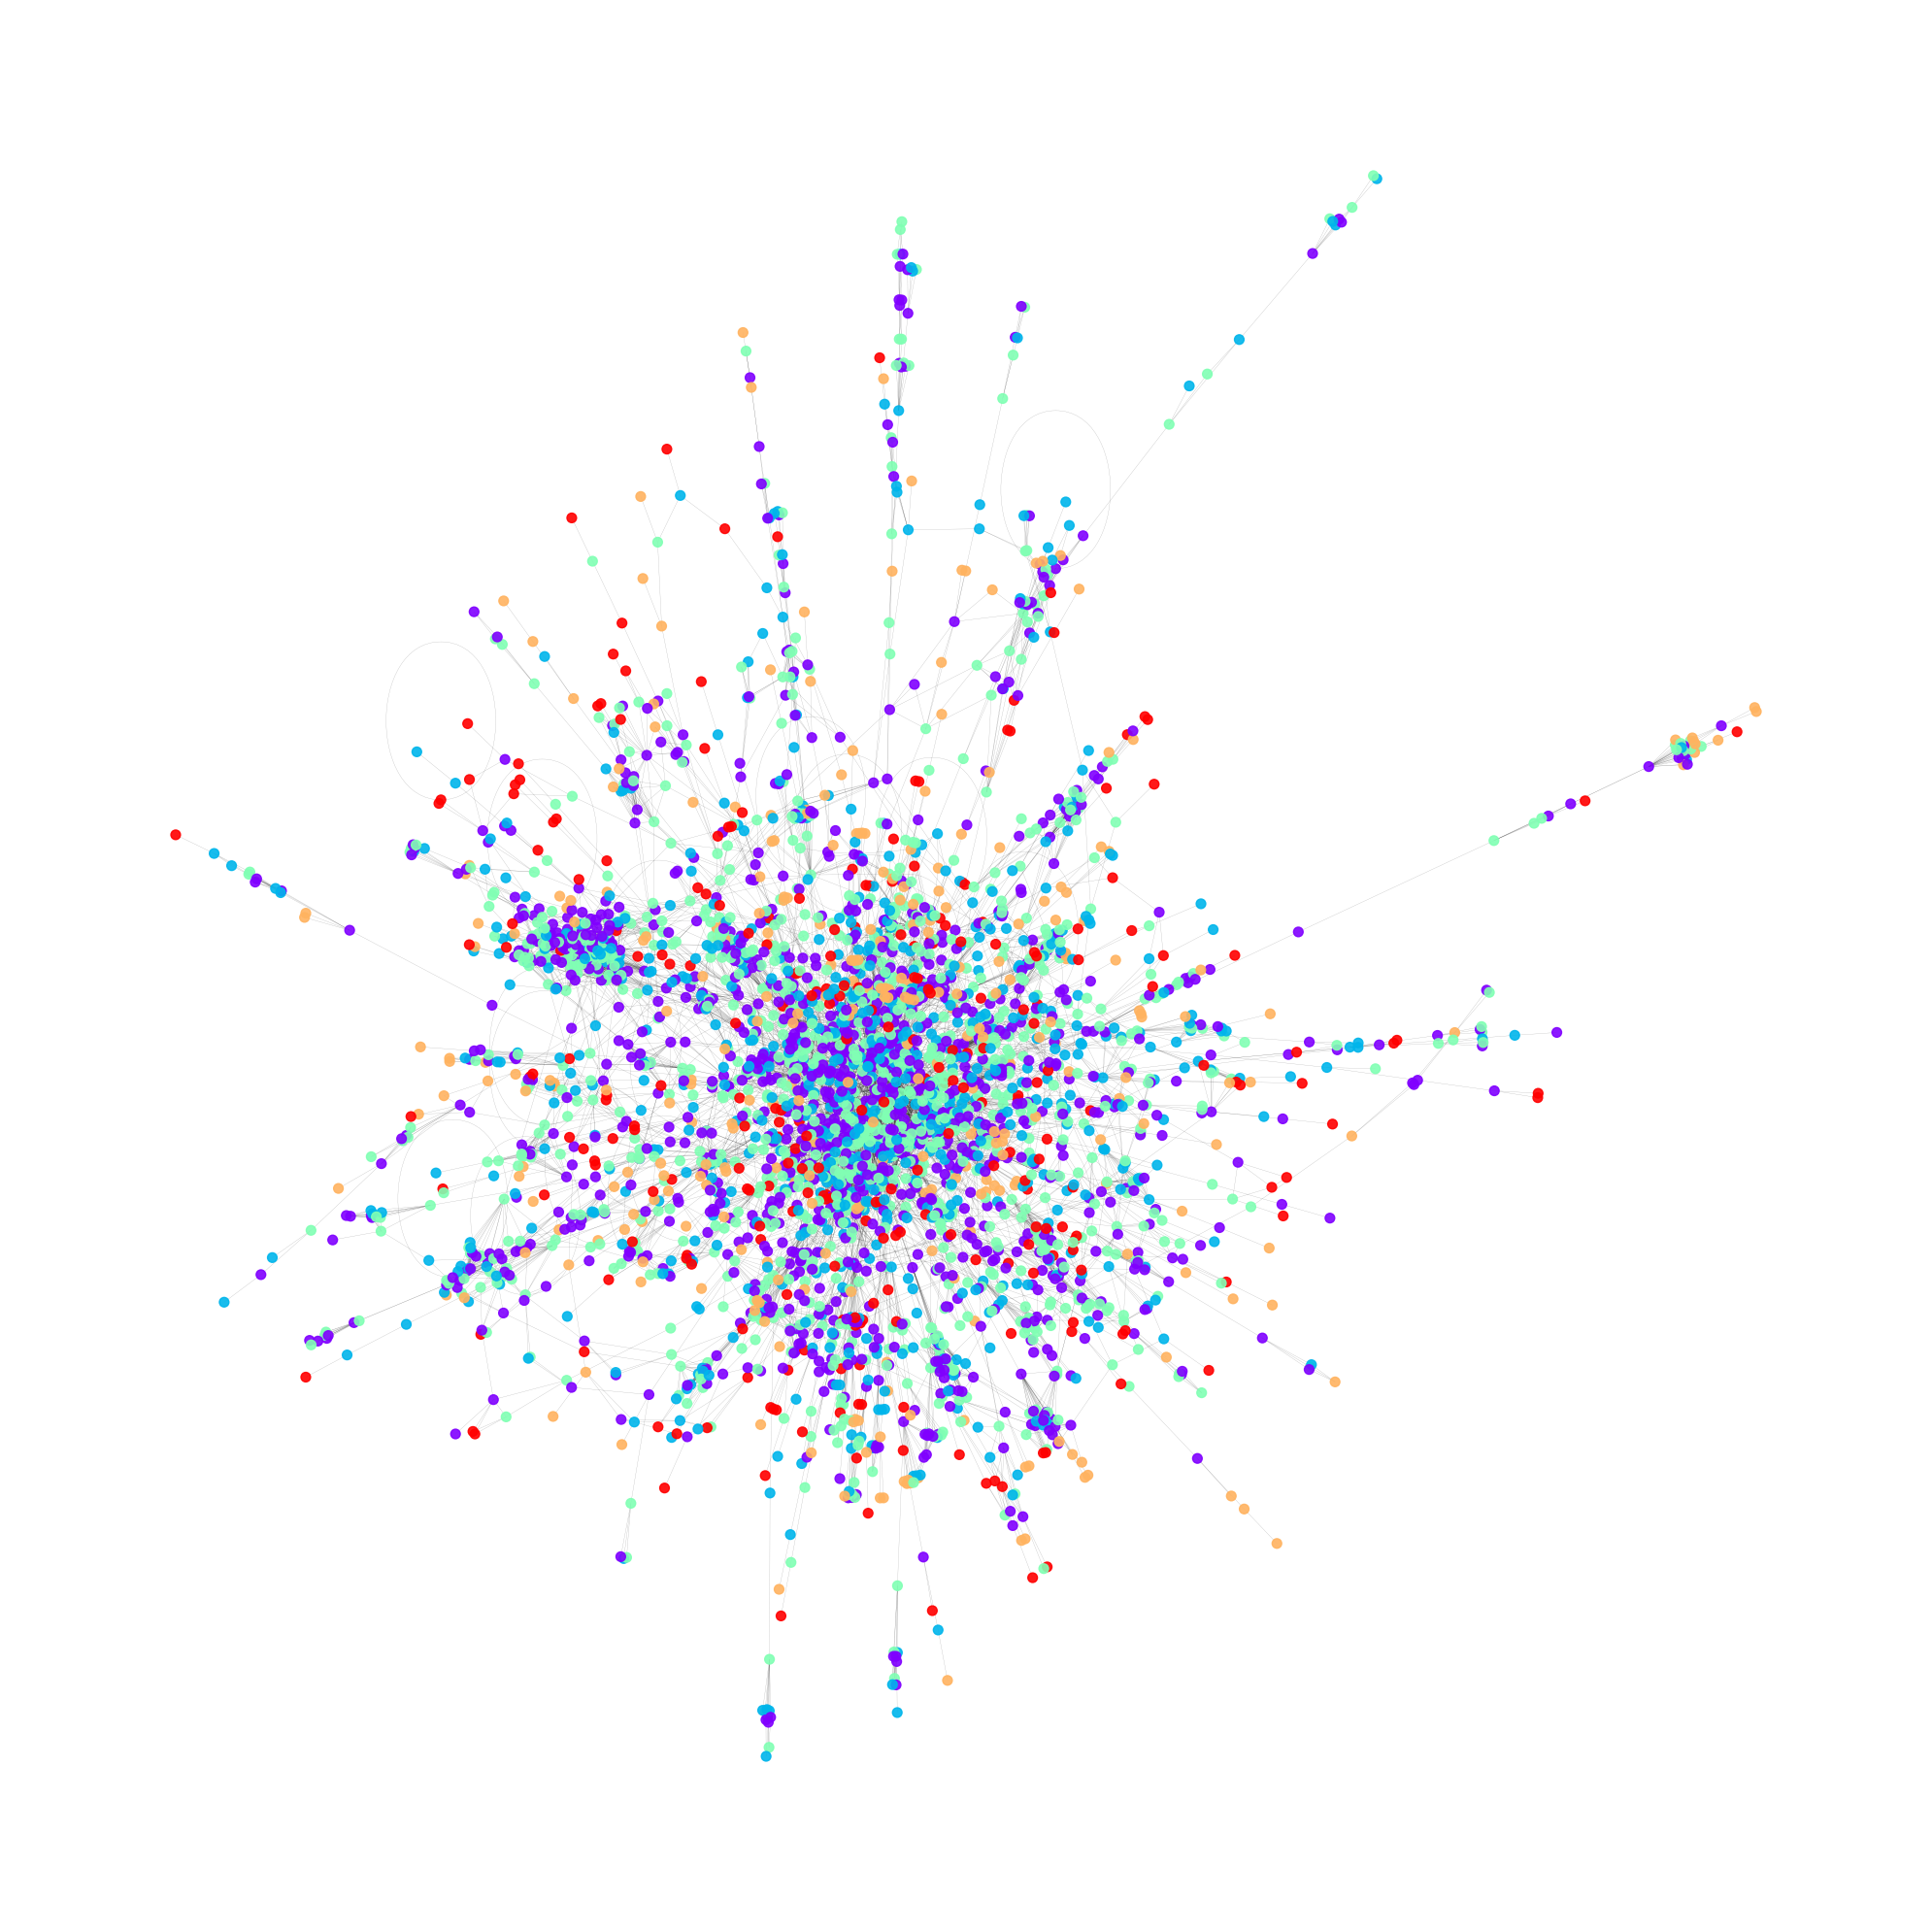

In [10]:
def visualize_communities(G, clusters):
    plt.figure(figsize=(20, 20))  # Large figure size for clarity
    
    # Use a layout that spreads nodes out more
    pos = nx.spring_layout(G, k=0.05, iterations=300)  # Increase k to spread out nodes more

    # Draw nodes with community clusters
    nodes = nx.draw_networkx_nodes(G, pos, node_color=clusters, cmap=plt.cm.rainbow, 
                                   node_size=50, alpha=0.9)
    
    # Draw edges with reduced opacity and thickness
    edges = nx.draw_networkx_edges(G, pos, alpha=0.3, width=0.2)
    
    # Draw node labels if the graph is not too dense
    # nx.draw_networkx_labels(G, pos, font_size=8, font_color='black')
    
    plt.axis('off')  # Turn off the axis
    plt.tight_layout()  # Fit the plot nicely into the figure
    
    plt.show()

visualize_communities(G, clusters)